In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, sys
from tqdm import tqdm
from datetime import datetime

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

from sklearn.decomposition import PCA


from autoencoder import Autoencoder
from solver import train_vali_all_epochs, dev_train_vali_all_epochs, test

In [2]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 128
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=6)

In [3]:
run_id = datetime.today().strftime("%Y-%m-%d_%H-%M-%S")
save_path = os.getenv("HOME") + '/sparsify_models/AE/MNIST/' +run_id +'/'
print(save_path)

/home/david/sparsify_models/AE/MNIST/2024-10-09_14-08-54/


In [4]:
model = Autoencoder(n_input=784, n_hidden_ls=[512, 128, 32], n_layers=3)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.99)
train_losses, vali_losses = train_vali_all_epochs(model, train_loader, test_loader, optimizer, n_epochs=3, device=torch.device('cuda'), save_path=save_path+'Static/')

Train Epoch: 0 [44928/60000 (100%)]	Loss: 0.000197: 100%|██████████| 469/469 [00:01<00:00, 247.88it/s]


====> Epoch: 0 Average loss: 0.0352


/home/david/Documents/UNI_LOCAL/PyTorch/MarkosCode/solver.py:266: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0196
Directory created: /home/david/sparsify_models/AE/MNIST/2024-10-09_14-08-54/Static/
Weights saved.


Train Epoch: 1 [44928/60000 (100%)]	Loss: 0.000182: 100%|██████████| 469/469 [00:01<00:00, 254.90it/s]

====> Epoch: 1 Average loss: 0.0183


====> Test set loss: 0.0171
Weights saved.


Train Epoch: 2 [44928/60000 (100%)]	Loss: 0.000181: 100%|██████████| 469/469 [00:01<00:00, 251.15it/s]


====> Epoch: 2 Average loss: 0.0174
====> Test set loss: 0.0169
Weights saved.
All train losses saved.


In [6]:
latent_list = []
model.eval()  # Model in evaluation mode

# Loop through validation data
with torch.no_grad():  # Gradients not calculated
    for batch_idx, (data, target) in enumerate(test_loader):
        # Convert to a PyTorch variable
        data = Variable(data).to('cuda')

        # Flatten the input data into a 2D tensor [batch_size, num_features]
        batch_size = data.size(0)
        input = data.view(batch_size, -1).to('cuda')

        # Pass through the encoder to get the latent representation
        encoded = model(input)[0]  # Returns encoded, decoded

        latent_list.append(encoded.cpu().numpy())

# Concatenate all latent representations into one matrix [L, K]
latent_matrix = np.concatenate(latent_list)

pca = PCA(n_components=2)
pca.fit(latent_matrix)

print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Singular Values:", pca.singular_values_)


Explained Variance Ratio: [0.11400357 0.08473057]
Singular Values: [83.11492 71.6539 ]


<Figure size 1000x600 with 0 Axes>

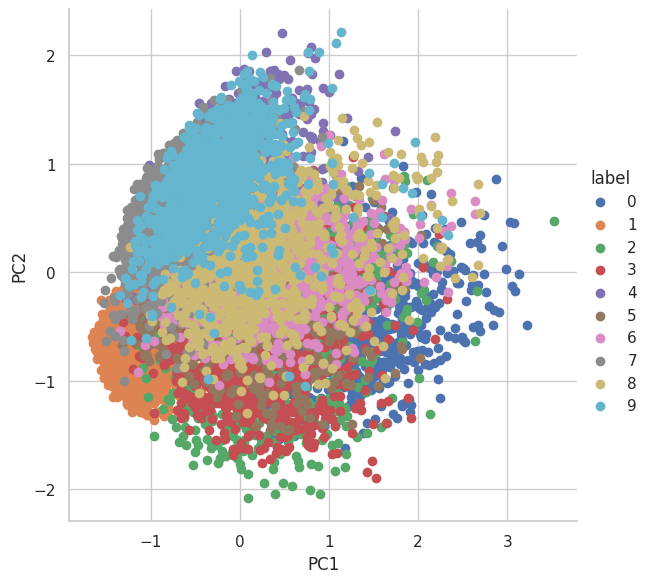

In [7]:
all_labels = []
for batch_idx, (data, labels) in enumerate(test_loader):
    all_labels.append(labels)
all_labels = torch.concatenate(all_labels)

latent_2d = pca.transform(latent_matrix)

df = pd.DataFrame({
    'PC1': latent_2d[:, 0],
    'PC2': latent_2d[:, 1],
    'label': all_labels
})

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.FacetGrid(df, hue='label', height=6) \
    .map(plt.scatter, 'PC1', 'PC2', alpha=1) \
    .add_legend()
plt.show()

In [8]:
print(df)

           PC1       PC2  label
0    -0.912718  0.590378      7
1     0.119216 -1.435732      2
2    -1.426713 -0.981371      1
3     1.535581 -0.159072      0
4    -0.237491  0.428032      4
...        ...       ...    ...
9995  0.934534 -0.521645      2
9996  0.723117 -0.886022      3
9997  0.055687  1.434716      4
9998 -0.332108 -0.028718      5
9999  1.631276  0.020776      6

[10000 rows x 3 columns]


In [9]:
latent_list = []
decoded_list = []
model.eval()  # Model in evaluation mode

# Loop through validation data
with torch.no_grad():  # Gradients not calculated
    # For each batch, find encodings
    for batch_idx, (data, target) in enumerate(test_loader):
        # Convert to a PyTorch variable
        data = Variable(data).to('cuda')

        # Flatten the input data into a 2D tensor [batch_size, num_features]
        batch_size = data.size(0)
        input = data.view(batch_size, -1).to('cuda')

        # Pass through the model to get the 32-dimensional vector (latent representation)
        encoded, decoded = model(input)

        latent_list.append(encoded.cpu().numpy())
        decoded_list.append(decoded)

# Concatenate all latent representations into one matrix [L, K]
latent_matrix = np.concatenate(latent_list)

pca = PCA(n_components=2)
pca.fit(latent_matrix)

all_labels = []
for batch_idx, (data, labels) in enumerate(test_loader):
    all_labels.append(labels)
all_labels = np.concatenate(all_labels)

latent_2d = pca.transform(latent_matrix)

df = pd.DataFrame({
    'PC1': latent_2d[:, 0],
    'PC2': latent_2d[:, 1],
    'label': all_labels
})


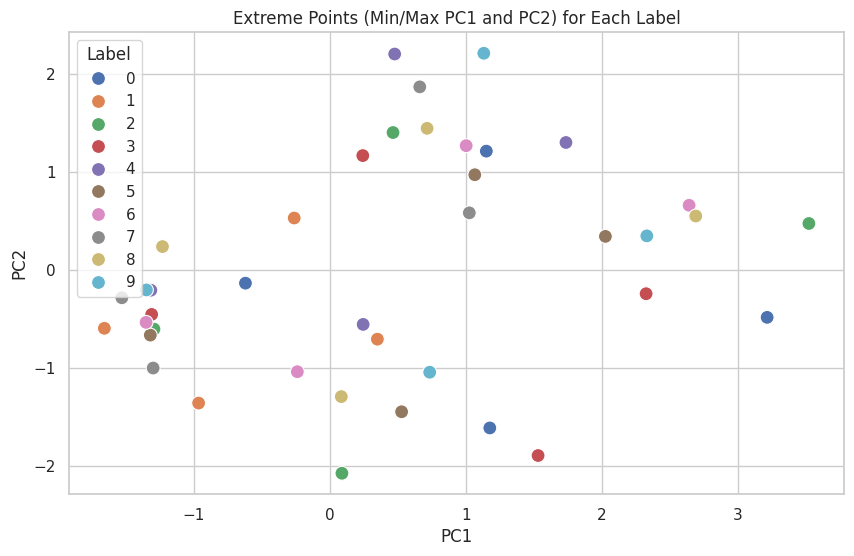

In [10]:

# Function to get min/max PC1 and PC2 for each label and return a DataFrame
def get_extreme_points(df, label):
    df_label = df[df['label'] == label]

    # Find the minimum and maximum values for PC1 and PC2
    min_PC1 = df_label['PC1'].min()
    max_PC1 = df_label['PC1'].max()
    min_PC2 = df_label['PC2'].min()
    max_PC2 = df_label['PC2'].max()

    # Find the rows corresponding to the extreme points
    min_PC1 = df_label[(df_label['PC1'] == min_PC1)]
    max_PC1 = df_label[(df_label['PC1'] == max_PC1)]
    min_PC2 = df_label[(df_label['PC2'] == min_PC2)]
    max_PC2 = df_label[(df_label['PC2'] == max_PC2)]

    # Concatenate the extreme points into one DataFrame
    extreme_points = pd.concat([min_PC1, max_PC1, min_PC2, max_PC2])

    return extreme_points

# Collect extreme points for each label
extreme_points_list = []
for label in range(10):
    extreme_points = get_extreme_points(df, label)
    extreme_points_list.append(extreme_points)

# Combine the extreme points into one DataFrame
extreme_points_df = pd.concat(extreme_points_list)

# Plot the extreme points using Seaborn
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create a scatter plot with only the extreme points
sns.scatterplot(data=extreme_points_df, x='PC1', y='PC2', hue='label', s=100, marker='o', palette="deep")

# Show the plot
plt.title('Extreme Points (Min/Max PC1 and PC2) for Each Label')
plt.legend(title='Label')
plt.show()



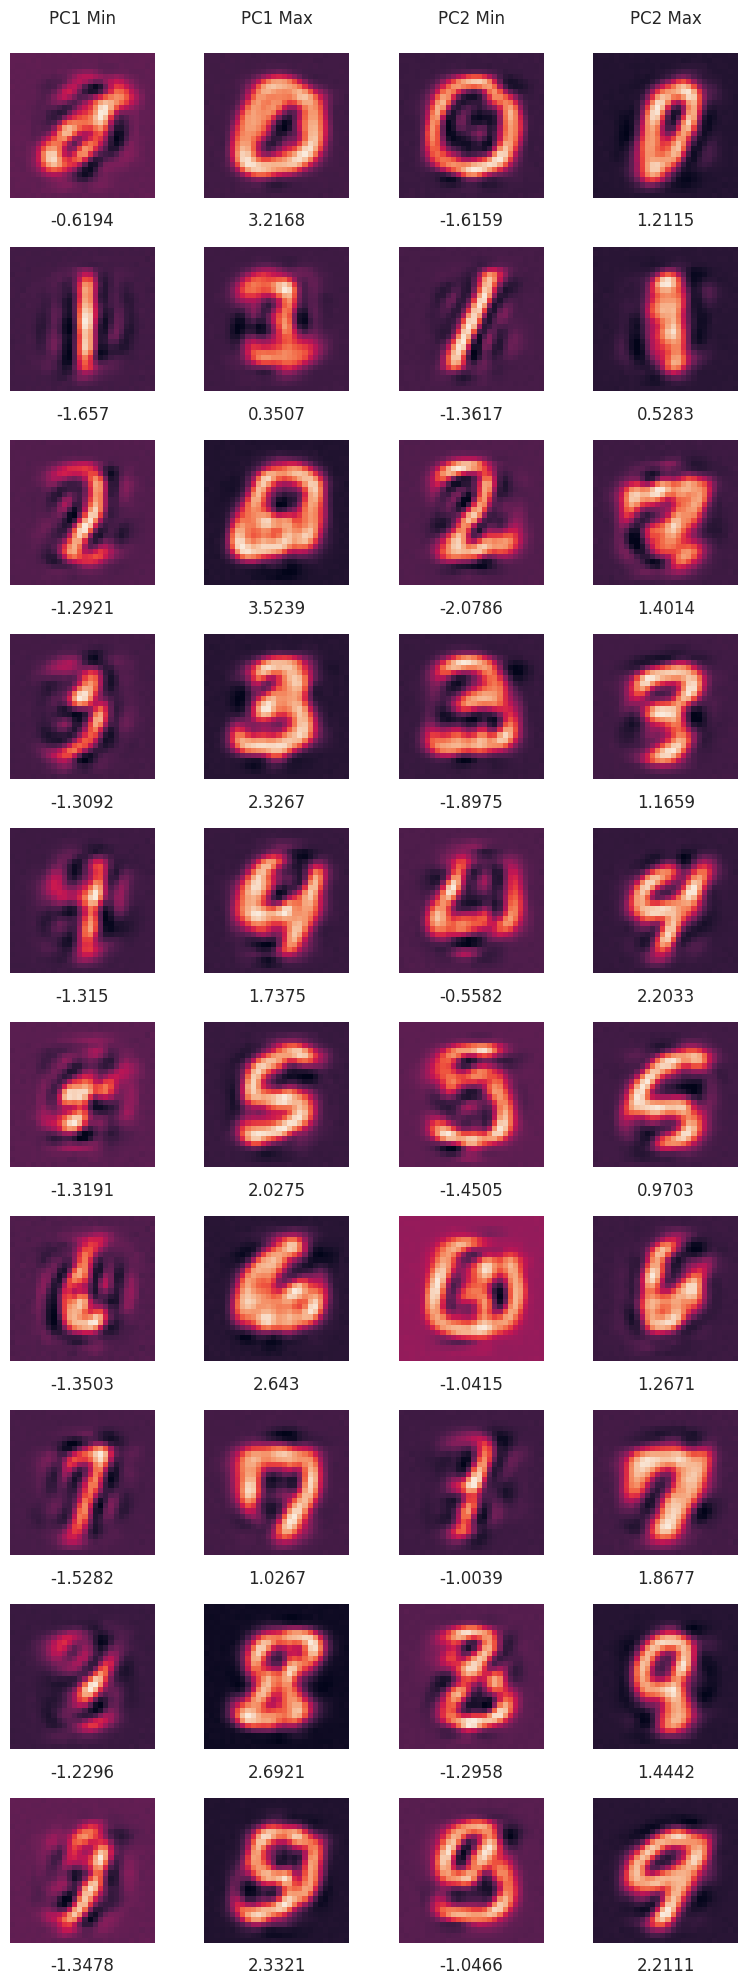

In [11]:
def index_finder(decoded_list, row_index):
    list_idx = row_index // 128
    batch_idx = row_index % 128

    return decoded_list[list_idx][batch_idx]

fig, axs = plt.subplots(10, 4, figsize=(8, 20))  # Adjust figure size
axs = axs.flatten()

for i, (idx, row) in enumerate(extreme_points_df.iterrows()):
    img = np.transpose(index_finder(decoded_list, idx).detach().cpu().numpy().reshape(1, 28, 28), (1, 2, 0))
    axs[i].imshow(img)
    
    axs[0].set_title('PC1 Min\n')
    axs[1].set_title('PC1 Max\n')
    axs[2].set_title('PC2 Min\n')
    axs[3].set_title('PC2 Max\n')

    axs[i].text(0.5, -0.1, round(row.get('PC1' if i % 4 < 2 else 'PC2'), 4), ha='center', va='top', transform=axs[i].transAxes)
    
    axs[i].axis('off')

plt.tight_layout()
plt.show()
